<a href="https://colab.research.google.com/github/Ashwin1234/CS-521-Project/blob/master/CS521Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import numpy as np
import re
import string
from datasets import load_dataset
from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.svm import SVC
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset = load_dataset("liar")


Using custom data configuration default


Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

Dataset liar downloaded and prepared to /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
dataset_train = pd.DataFrame(dataset['train'])
dataset_test = pd.DataFrame(dataset['test'])
dataset_validate = pd.DataFrame(dataset['validation'])

In [8]:
dataset_train.size

143766

In [9]:
dataset_train.describe()

,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts
count,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000
mean,2.136722,11.560132,13.313857,17.195637,16.490505,6.202746
std,1.585507,19.006447,24.140583,35.948211,36.251253,16.117701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,3.000000,3.000000,1.000000
75%,3.000000,12.000000,15.000000,13.000000,11.000000,5.000000
max,5.000000,70.000000,114.000000,160.000000,163.000000,105.000000


In [10]:
dataset_train.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


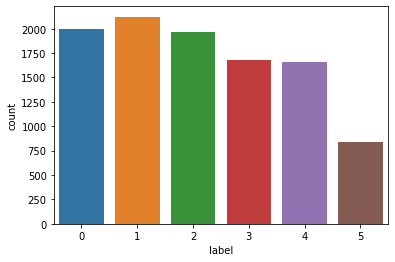

In [11]:
sns.countplot(x = 'label', data = dataset_train)

KeyboardInterrupt: ignored

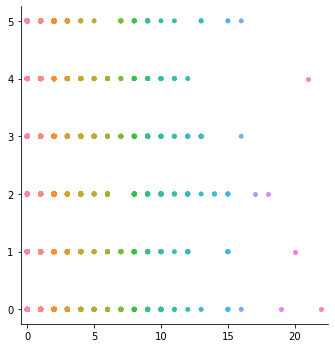

In [19]:
sns.catplot(x='party_affiliation', y='label', kind = 'swarm', data = dataset_train)

In [12]:

dataset_train['statement'] = dataset_train.apply(lambda row : row['statement'].lower(), axis = 1)


In [15]:
dataset_train['statement'] = dataset_train['statement'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

In [13]:
# Removing stop words
dataset_train['statement'] = dataset_train.apply(lambda row: remove_stopwords(row['statement']),axis = 1)

In [14]:
#Tokenization

dataset_train['statement'] = dataset_train.apply(lambda row : list(tokenize(row['statement'])), axis = 1)

In [15]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
dataset_train['comment'] = dataset_train.apply(lambda row : list(lemmatizer.lemmatize(word) for word in row['statement']),axis = 1)

In [19]:
dataset_train['statement'] = dataset_train.apply(lambda row: list(word.strip() for word in row['statement']), axis = 1)

In [16]:

dataset_train['statement']

0        [says, annies, list, political, group, support...
1        [decline, coal, start, started, natural, gas, ...
2        [hillary, clinton, agrees, john, mccain, by, v...
3        [health, care, reform, legislation, likely, ma...
4               [economic, turnaround, started, end, term]
                               ...                        
10264    [larger, number, shark, attacks, florida, case...
10265     [democrats, party, atlanta, metro, area, blacks]
10266    [says, alternative, social, security, operates...
10267    [lifting, u, s, cuban, embargo, allowing, trav...
10268    [department, veterans, affairs, manual, tellin...
Name: statement, Length: 10269, dtype: object

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
!pip install datasets

     |████████████████████████████████| 325 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 58.4 MB/s 
     |████████████████████████████████| 136 kB 68.3 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 212 kB 53.7 MB/s 
     |████████████████████████████████| 127 kB 69.1 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 271 kB 46.2 MB/s 
     |████████████████████████████████| 144 kB 45.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [38]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.8 MB/s 
     |████████████████████████████████| 6.6 MB 33.8 MB/s 
     |████████████████████████████████| 596 kB 57.8 MB/s 
     |████████████████████████████████| 895 kB 56.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [67]:
x_train = dataset_train['statement']
y_train = dataset_train['label']

In [49]:
# TF-IDF
count_vectorizer = CountVectorizer()
count_vectorizer.fit(x_train)
freq_term_matrix = count_vectorizer.transform(x_train)
tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

AttributeError: ignored

In [22]:
x_train,x_test,y_train,y_test = train_test_split(tf_idf_matrix,y_train,test_size = 0.3)

In [19]:
lr = LogisticRegression()

In [23]:
lr.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [24]:
lr.score(x_test,y_test)

0.2310938007140539

In [29]:
mnb = MultinomialNB()

In [30]:
mnb.fit(x_train,y_train)

MultinomialNB()

In [31]:
mnb.score(x_test,y_test)

0.2317429406037001

In [34]:
rfc = RandomForestClassifier()

In [35]:
rfc.fit(x_train,y_train)

RandomForestClassifier()

In [36]:
rfc.score(x_test,y_test)

0.24407659850697824

In [17]:
input_filename = '/content/drive/MyDrive/glove.6B.100d.txt'
output_filename = 'glove.6B.100d.txt.word2vec'
#model = gensim.models.Word2Vec(list(dataset_train['statement']), size=350, window=10, min_count=2, iter=20, sg = 1)
glove2word2vec(input_filename,output_filename)

(400000, 100)

In [19]:
model = KeyedVectors.load_word2vec_format(output_filename, binary = False)

In [69]:
#model = Word2Vec(dataset_train['statement'],size = 50,workers = 3,window = 3, sg = 1, min_count = 1)

In [20]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model[doc], axis=0)

In [21]:
dataset_train['statement'] = dataset_train['statement'].apply(document_vector)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
#X = list(dataset_train['statement'])
#Y = dataset_train['label']
Y = dataset_train['label']
X = model.wv.syn0[: len(dataset_train['label'])]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


10269

In [23]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3)

In [24]:
lr = LogisticRegression()

In [25]:
lr.fit(x_train,y_train)

LogisticRegression()

In [26]:
print(lr.score(x_test,y_test))

0.19149626744563453


In [27]:

gnb = GaussianNB()
gnb.fit(x_train,y_train)

GaussianNB()

In [28]:
print(gnb.score(x_test,y_test))

0.18208373904576436


In [29]:
rfc = RandomForestClassifier()

In [30]:
rfc.fit(x_train,y_train)

RandomForestClassifier()

In [32]:
print(rfc.score(x_test,y_test))

0.1872768581629341


In [57]:
svm = SVC(gamma = 'auto')
svm.fit(x_train,y_train)

SVC(gamma='auto')

In [58]:
print(svm.score(x_test,y_test))

0.19636481661798116


In [69]:
X.shape

(10269, 100)

In [33]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Flatten

In [34]:

model = Sequential()
model.add(LSTM(100,input_shape = (100,1) , return_sequences = True))

model.add(Dense(50, activation = 'ReLU'))
model.add(Dense(1))
#model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
model.compile(loss ='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [35]:
history = model.fit(x_train,y_train,validation_data = (x_test,y_test), epochs = 5)

Epoch 1/5
225/225 [==============================] - 22s 87ms/step - loss: -13.3410 - accuracy: 0.2012 - val_loss: -16.8053 - val_accuracy: 0.2114
Epoch 2/5
225/225 [==============================] - 19s 84ms/step - loss: -16.8958 - accuracy: 0.2044 - val_loss: -17.0750 - val_accuracy: 0.2115
Epoch 3/5
225/225 [==============================] - 19s 84ms/step - loss: -17.0579 - accuracy: 0.2046 - val_loss: -17.2427 - val_accuracy: 0.2116
Epoch 4/5
225/225 [==============================] - 19s 83ms/step - loss: -17.1271 - accuracy: 0.2046 - val_loss: -17.2461 - val_accuracy: 0.2116
Epoch 5/5
225/225 [==============================] - 20s 87ms/step - loss: -17.1313 - accuracy: 0.2046 - val_loss: -17.2516 - val_accuracy: 0.2116


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dense (Dense)               (None, 100, 50)           5050      
                                                                 
 dense_1 (Dense)             (None, 100, 1)            51        
                                                                 
Total params: 45,901
Trainable params: 45,901
Non-trainable params: 0
_________________________________________________________________


In [58]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [59]:
def preprocess_function(dataset_train):
    return tokenizer(dataset_train["statement"], truncation=True)

In [60]:
dataset_tokenized = dataset.map(preprocess_function,batched = True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-4ad5a7908d2ec403.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-a9d19f5ee5d4e35f.arrow


In [61]:
data_collector = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [69]:
tf_train_set = dataset_tokenized['train'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle = True,
    batch_size = 16,
    collate_fn = data_collector

)
tf_test_set = dataset_tokenized['test'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle = False,
    batch_size = 16,
    collate_fn = data_collector
)

In [70]:
model2 = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_59', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [71]:
model2.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

In [73]:
model2.fit(x=tf_train_set, validation_data = tf_test_set, epochs = 5)

Epoch 1/5


TypeError: ignored